<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import numpy as np
import os
from astropy.io import fits
import miricoord.mrs.mrs_tools as mmrs
import miricoord.tel.tel_tools as jwst
import miricoord.mrs.makesiaf.makesiaf_mrs as makesiaf
from pydl.pydlutils import yanny
from array_indices import *
import idlwrap
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
rootdir= False
siafdir=False
outfile='covmap.fits'
outdir = './'
channel = '3B'
dith = [1,2,3,4]

global dithfile
#dithfile='mrs_dithers_orig.txt'
dithfile='mrs_dithers_test.txt'

#wave = 5.6

In [3]:
def output_result(maxoffset, channel, phase_pix, phase_slice, covmap):
    if (channel == '1A'): psf = 0.31
    if (channel == '1B'): psf = 0.31
    if (channel == '1C'): psf = 0.31
    if (channel == '2A'): psf = 0.31 * (8.90 / 8.0)
    if (channel == '2B'): psf = 0.31 * (10.28 / 8.0)
    if (channel == '2C'): psf = 0.31 * (11.87 / 8.0)
    if (channel == '3A'): psf = 0.31 * (13.67 / 8.0)
    if (channel == '3B'): psf = 0.31 * (15.80 / 8.0)
    if (channel == '3C'): psf = 0.31 * (18.24 / 8.0)
    if (channel == '4A'): psf = 0.31 * (21.10 / 8.0)
    if (channel == '4B'): psf = 0.31 * (24.72 / 8.0)
    if (channel == '4C'): psf = 0.31 * (28.82 / 8.0)

    print('Max offset (arcsec): ' + str(maxoffset))
    print('Max offset (FWHM): ' + str(maxoffset / psf))

    try:
        fits.writeto('phase_pix.fits', data=phase_pix)
    except:
        print("File 'phase_pix.fits' already exists. \n")

    try:
        fits.writeto('phase_slice.fits', data=phase_slice)
    except:
        print("File 'phase_slice.fits' already exists. \n")

    try:
        fits.writeto(outfile, data=covmap)
    except:
        print("File 'covmap.fits' already exists. \n")

    return

In [4]:
def make_covmap(goodval, phase_slice, phase_pix):
    
    covmap = np.zeros_like(phase_slice)
    
    for i,j in zip(goodval[0],goodval[1]):
        
        slicevals = phase_slice[:, i, j]
        pixvals = phase_pix[:,i,j]

        hit_s = np.zeros(100)

        for m in range(0, slicevals.size):
            sval = int(round(slicevals[m] * 100))

            if (sval == 100):
                sval = 0  # Wrap around

            if (sval < 25):
                hit_s[sval:sval + 25] = 1
                hit_s[0:sval] = 1
                hit_s[100 - (25 - sval):] = 1

            if ((sval >= 25) and (sval < 75)):
                hit_s[sval - 25:sval + 25] = 1

            if (sval >= 75):
                hit_s[sval - 25:sval] = 1
                hit_s[sval:] = 1
                hit_s[0:sval - 75] = 1

        hit_p = np.zeros(100)

        for m in range(0, pixvals.size):
            pval = int(round(pixvals[m] * 100))

            if (pval == 100):
                pval = 0  # ; Wrap around

            if (pval < 25):
                hit_p[pval:pval + 25] = 1
                hit_p[0:pval] = 1
                hit_p[100 - (25 - pval):] = 1

            if ((pval >= 25) and (pval < 75)):
                hit_p[pval - 25:pval + 25] = 1

            if (pval >= 75):
                hit_p[pval - 25:pval] = 1
                hit_p[pval:] = 1
                hit_p[0:pval - 75] = 1

        temp_s = idlwrap.where(hit_s == 1)
        nhit_s = len(temp_s)

        temp_p = idlwrap.where(hit_p == 1)
        nhit_p = len(temp_p)

        covmap[0,i,j] = nhit_s / 100.
        covmap[1,i,j] = nhit_p / 100.

    return covmap

In [5]:
def make_phase_im(rall, deall, racen, decen, dra, ddec, nra, ndec, lam, ndith):
    phase_slice = np.zeros((ndith, ndec, nra))
    phase_pix = np.zeros((ndith, ndec, nra))

    for i in range(0, ndith):
        # Transform to V2,V3 locations
        # WARNING; code will fail if ROLL != 0
        # Note that we MUST do -dra and +ddec cuz of how the Ideal frame is defined!!

        v2all, v3all, _ = jwst.jwst_radectov2v3(rall, deall, v2ref=-8.3942412 * 60, v3ref=-5.3123744 * 60,
                                                rollref=1e-5, raref=racen - dra[i], decref=decen + ddec[i])

        v2 = v2all.reshape(ndec, nra)
        v3 = v3all.reshape(ndec, nra)

        # Tranform to a,b locations
        aall, ball = mmrs.v2v3toab(v2all, v3all, channel)

        a = aall.reshape(ndec, nra)
        b = ball.reshape(ndec, nra)

        try:
            if lam == -1:
                #lam = np.ones_like(aall) * -1
                lam = [lam]
        except:
            lam = lam

        print(aall[0])    
        vals = mmrs.abltoxy(aall, ball, lam, channel)

        phase_slice[i, :, :] = vals['slicephase'].reshape(ndec, nra) + 0.5
        phase_pix[i, :, :] = vals['pixelphase'].reshape(ndec, nra) + 0.5

    return vals, phase_slice, phase_pix

In [6]:
def assess_dith(rootdir=False, siafdir=False,
                outfile='covmap.fits', channel='1A',
                dith=[1, 2, 3, 4], wave=False,
                da=None, db=None):
    # setup
    ch = int(channel[0])
    sband = channel[1]

    if rootdir == False:
        rootdir = os.getenv('MIRICOORD_DATA_DIR')+'/dithers/temp/'
    if siafdir == False:
        siafdir = os.getenv('MIRICOORD_DATA_DIR')

    dithers = pd.read_csv(rootdir+dithfile,header=2,sep='\s+',index_col=0)

    dra = dithers.dXIdeal[dith].array / 3600.
    ddec = dithers.dYIdeal[dith].array / 3600.

    siaf = makesiaf.create_siaf_oneband(channel)

    maxalpha = siaf['inscr_alpha_corners'][0] * 2
    minalpha = siaf['inscr_alpha_corners'][2] * 2
    maxbeta = siaf['inscr_beta_corners'][0] * 2
    minbeta = siaf['inscr_beta_corners'][2] * 2

    if (da != None) and (db != None):
        v2, v3 = mmrs.abtov2v3(da, db, channel)

        zpv2, zpv3 = mmrs.abtov2v3(0, 0, channel)

        zpx, zpy = mmrs.v2v3_to_xyideal(zpv2, zpv3)

        tempx, tempy = mmrs.v2v3_to_xyideal(v2, v3)

        dra = (tempx - zpx) / 3600.
        ddec = (tempy - zpy) / 3600.

    racen = 45.
    decen = 0.
    # WARNING- this code will fail if DEC != 0 !!!!
    dtheta = 0.02
    nra = int(np.abs(maxalpha - minalpha) / dtheta)
    ndec = int(np.abs(maxbeta - minbeta) / dtheta)

    if wave != False:
        lam = np.ones((nra * ndec)) * wave
    else:
        lam = np.ones((nra * ndec)) * -1

    ra = (np.arange(nra) * dtheta + minalpha) / 3600. + racen
    dec = (np.arange(ndec) * dtheta + minbeta) / 3600. + decen

    racen = (min(ra) + max(ra)) / 2.
    decen = (min(dec) + max(dec)) / 2.

    skyloc = np.zeros((2, ndec, nra))

    for i in range(0, nra - 1):
        skyloc[0, :, i] = ra[i]

    for i in range(0, ndec - 1):
        skyloc[1, i, :] = dec[i]

    rall = skyloc[0, :, :].reshape(nra * ndec)
    deall = skyloc[1, :, :].reshape(nra * ndec)

    ndith = len(dith)

    # construct phase images
    vals, phase_slice, phase_pix = make_phase_im(rall, deall, racen, decen, dra, ddec, nra, ndec, lam, ndith)

    temp = np.sum(phase_slice, axis=0)
    goodval = np.where(temp > -10)

    covmap = make_covmap(goodval, phase_slice, phase_pix)

    temp = covmap[0, :, :]
    indx = np.where(temp!=0)
    
    nindx = len(indx[0])
    print('Coverage area: ' + str(nindx * dtheta * dtheta) + ' arcsec^2')

    offsets = np.sqrt((dra - dra[0]) ** 2 + (ddec - ddec[0]) ** 2)
    maxoffset = max(offsets) * 3600.

    output_result(maxoffset, channel, phase_pix, phase_slice, covmap)

    return phase_pix, phase_slice, covmap

In [7]:
phase_pix, phase_slice, covmap = assess_dith(channel=channel,dith=dith)

-3.29841973337
-5.2580761393
-3.39614598751
-5.35172234412
Coverage area: 18.48 arcsec^2
Max offset (arcsec): 2.42375776052
Max offset (FWHM): 3.95877135243
File 'phase_pix.fits' already exists. 

File 'phase_slice.fits' already exists. 

File 'covmap.fits' already exists. 



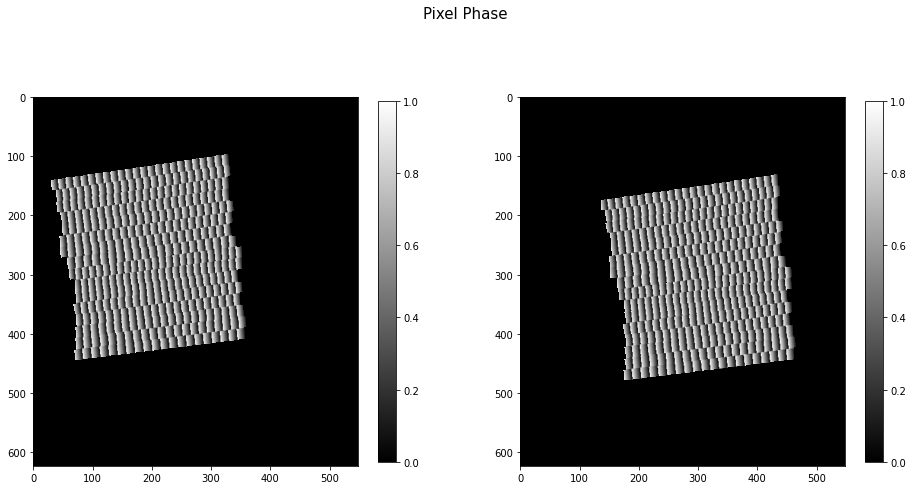

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
fig.suptitle('Pixel Phase',fontsize=15)
a = ax1.imshow(phase_pix[0],vmin=0,vmax=1,cmap='gray')
b = ax2.imshow(phase_pix[1],vmin=0,vmax=1,cmap='gray')
fig.colorbar(a,ax=ax1,shrink=0.83)
fig.colorbar(b,ax=ax2,shrink=0.83)

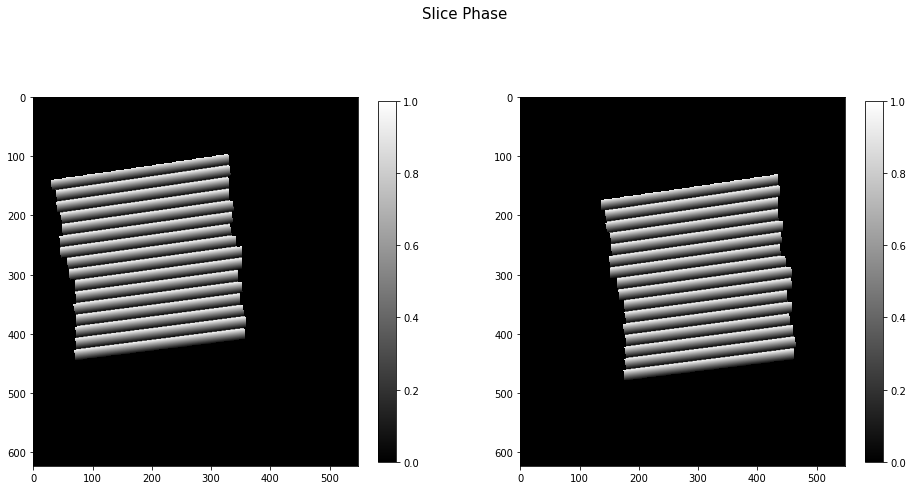

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
fig.suptitle('Slice Phase',fontsize=15)
a = ax1.imshow(phase_slice[0],vmin=0,vmax=1,cmap='gray')
b = ax2.imshow(phase_slice[1],vmin=0,vmax=1,cmap='gray')
fig.colorbar(a,ax=ax1,shrink=0.83)
fig.colorbar(b,ax=ax2,shrink=0.83)

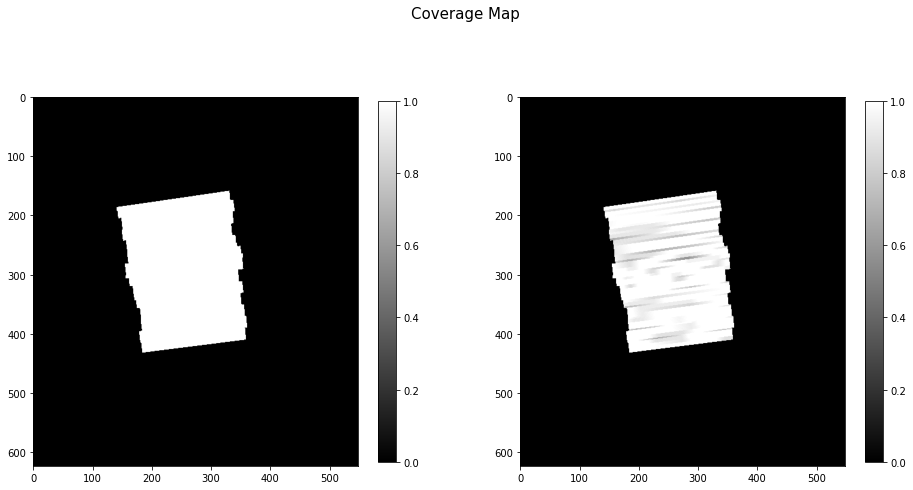

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
fig.suptitle('Coverage Map',fontsize=15)
a = ax1.imshow(covmap[0],vmin=0,vmax=1,cmap='gray')
b = ax2.imshow(covmap[1],vmin=0,vmax=1,cmap='gray')
fig.colorbar(a,ax=ax1,shrink=0.83)
fig.colorbar(b,ax=ax2,shrink=0.83)

In [11]:
print(covmap.shape)
indx=np.where(covmap[0] != 0)
print('Beta coverage:',np.mean(covmap[0][indx]),' +- ',np.std(covmap[0][indx]))
indx=np.where(covmap[1] != 0)
print('Alpha coverage:',np.mean(covmap[1][indx]),' +- ',np.std(covmap[1][indx]))




(4, 623, 548)
Beta coverage: 1.0  +-  0.0
Alpha coverage: 0.963936580087  +-  0.0622603377566
